In [3]:
pip install bayesian-optimization


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization

In [7]:
# Load dataset
df = pd.read_csv("credit_card_fraud_dataset_.csv")
print(f"Dataset Shape: {df.shape}")


Dataset Shape: (100000, 7)


In [8]:
#Data Preprocessing
df.dropna(inplace=True)
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["TransactionHour"] = df["TransactionDate"].dt.hour
df["TransactionDay"] = df["TransactionDate"].dt.dayofweek

# Apply get_dummies to TransactionType and Location columns
df = pd.get_dummies(df, columns=["TransactionType", "Location"], drop_first=True)
df.drop(columns=["TransactionDate", "TransactionID"], inplace=True)

# Ensure 'Amount' is included in the features
X = df.drop(columns=["IsFraud"])
y = df["IsFraud"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)


In [9]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [10]:
 #Handle unknown locations (assign a default value if the location is not one of the known locations)
# The correct way to refer to location columns is by looking at column names of the transformed DataFrame

# Get location-related columns after one-hot encoding
location_columns = [col for col in df.columns if "Location" in col]
print(f"Location Columns: {location_columns}")

def handle_unknown_location(X_input, known_location_columns):
    # Iterate over the location columns and set unknown locations to 0
    for i, location_column in enumerate(known_location_columns):
        if location_column not in df.columns:
            X_input[:, i] = 0  # Assign a default value (zero) to unknown location
    return X_input

# Call the function to handle unknown locations during model inference
X_train = handle_unknown_location(X_train, location_columns)
X_test = handle_unknown_location(X_test, location_columns)

Location Columns: ['Location_Dallas', 'Location_Houston', 'Location_Los Angeles', 'Location_New York', 'Location_Philadelphia', 'Location_Phoenix', 'Location_San Antonio', 'Location_San Diego', 'Location_San Jose']


In [11]:
# Bayesian Optimization for DNN
def dnn_evaluate(learning_rate, dropout1, dropout2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0)
    y_pred_prob = model.predict(X_val)
    return f1_score(y_val, (y_pred_prob > 0.5).astype(int))

pbounds = {'learning_rate': (0.0001, 0.01), 'dropout1': (0.2, 0.5), 'dropout2': (0.1, 0.4)}
optimizer = BayesianOptimization(f=dnn_evaluate, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)
best_params = optimizer.max['params']


|   iter    |  target   | learni... | dropout1  | dropout2  |
-------------------------------------------------------------
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
| 1         | 0.8352084 | 0.0038079 | 0.4852142 | 0.3195981 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 2         | 0.8582167 | 0.0060267 | 0.2468055 | 0.1467983 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
| 3         | 0.8390485 | 0.0006750 | 0.4598528 | 0.2803345 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 4         | 0.8455180 | 0.0071099 | 0.2061753 | 0.3909729 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 5         | 0.8556986 | 0.0083411 | 0.2637017 | 0.1545474 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 6         | 0.8400058 | 0.0001    | 0.2       | 0.2116077 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
| 7         | 0.8416092 | 0.0048080 | 0.3546178 | 0.3360930 |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 8         | 0.8680574 | 0.0019349 | 0.2536300 | 0.1       |
495/495 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
| 9        

In [13]:
# Create optimized DNN model
def create_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(best_params['dropout1']),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(best_params['dropout2']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_model = create_dnn()
dnn_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)], verbose=1)


Epoch 1/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8263 - loss: 0.3704 - val_accuracy: 0.8616 - val_loss: 0.2970 - learning_rate: 0.0019
Epoch 2/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8572 - loss: 0.3088 - val_accuracy: 0.8650 - val_loss: 0.2876 - learning_rate: 0.0019
Epoch 3/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8581 - loss: 0.3012 - val_accuracy: 0.8658 - val_loss: 0.2793 - learning_rate: 0.0019
Epoch 4/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8610 - loss: 0.2946 - val_accuracy: 0.8658 - val_loss: 0.2764 - learning_rate: 0.0019
Epoch 5/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8613 - loss: 0.2914 - val_accuracy: 0.8667 - val_loss: 0.2744 - learning_rate: 0.0019
Epoch 6/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8638 - loss: 0.2883 - val_accuracy: 0.8698 - val_loss: 0.2689 - learning_rate: 0.0019
Epoch 7/30
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8624 

1238/1238 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
DNN Model Performance:
Accuracy: 0.8790
F1 Score: 0.8678
Matthews Correlation Coefficient (MCC): 0.7693
ROC-AUC Score: 0.9580
Precision-Recall AUC: 0.9653

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     19800
           1       0.96      0.79      0.87     19800

    accuracy                           0.88     39600
   macro avg       0.89      0.88      0.88     39600
weighted avg       0.89      0.88      0.88     39600



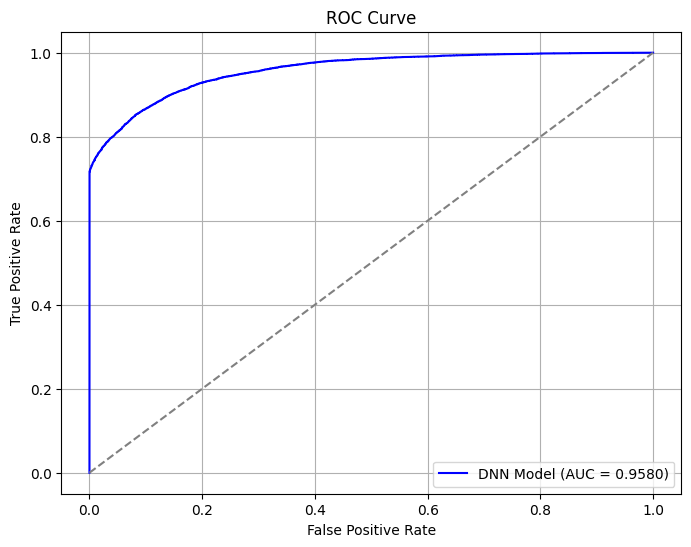

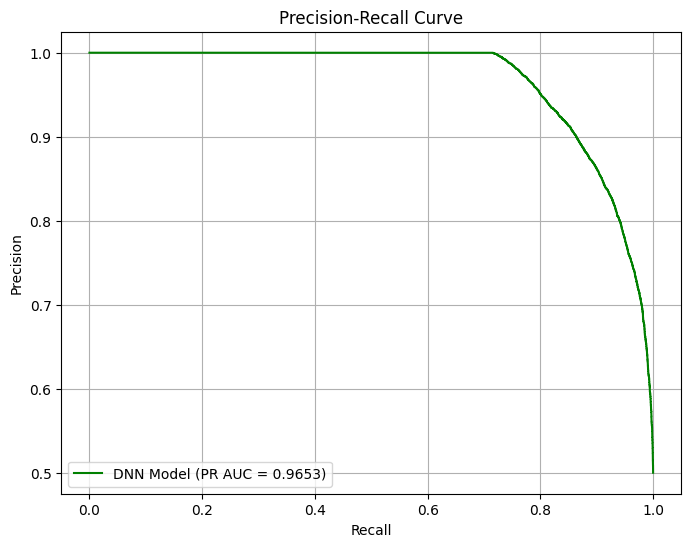

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

# Evaluate DNN model
y_pred_prob_dnn = dnn_model.predict(X_test)
y_pred_dnn = (y_pred_prob_dnn > 0.5).astype(int)

# Compute DNN performance metrics
dnn_accuracy = accuracy_score(y_test, y_pred_dnn)
dnn_f1 = f1_score(y_test, y_pred_dnn)
dnn_mcc = matthews_corrcoef(y_test, y_pred_dnn)
dnn_roc_auc = roc_auc_score(y_test, y_pred_prob_dnn)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_dnn)
dnn_pr_auc = auc(recall, precision)

print(f"DNN Model Performance:")
print(f"Accuracy: {dnn_accuracy:.4f}")
print(f"F1 Score: {dnn_f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {dnn_mcc:.4f}")
print(f"ROC-AUC Score: {dnn_roc_auc:.4f}")
print(f"Precision-Recall AUC: {dnn_pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dnn))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_dnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"DNN Model (AUC = {dnn_roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"DNN Model (PR AUC = {dnn_pr_auc:.4f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Confusion Matrix
conf_matrix = pd.crosstab(y_test, y_pred_dnn, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import deque
import random


In [4]:
class FraudDetectionEnv(gym.Env):
    def __init__(self, data_file):
        super(FraudDetectionEnv, self).__init__()
        self.data = pd.read_csv(data_file)

        # Ensure proper numeric conversion
        self.data = self.data.select_dtypes(include=[np.number])

        self.scaler = StandardScaler()
        self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])

        self.state_idx = 0
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.data.shape[1] - 1,), dtype=np.float32)

    def reset(self):
        self.state_idx = 0
        return self.data.iloc[self.state_idx, :-1].values

    def step(self, action):
        reward = 1 if action == self.data.iloc[self.state_idx, -1] else -1
        self.state_idx += 1
        done = self.state_idx >= len(self.data)
        next_state = self.data.iloc[self.state_idx, :-1].values if not done else np.zeros(self.observation_space.shape)
        return next_state, reward, done, {}

# Initialize the environment
env = FraudDetectionEnv('credit_card_fraud_dataset_.csv')


/tmp/ipython-input-4-2260629684.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.73203349 -1.73199885 -1.73196421 ...  1.73196421  1.73199885
  1.73203349]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])
/tmp/ipython-input-4-2260629684.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.64535719 -1.3600847  -0.37295009 ...  0.65228445  0.49295746
  0.60033   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.iloc[:, :-1] = self.scaler.fit_transform(self.data.iloc[:, :-1])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):
    def __init__(self, input_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.dropout(x, p=0.25, train=True)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [6]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return torch.tensor(states, dtype=torch.float32).to(device), \
               torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device), \
               torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device), \
               torch.tensor(next_states, dtype=torch.float32).to(device), \
               torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    def __len__(self):
        return len(self.memory)


In [9]:
class Agent:
    def __init__(self, input_dim, action_size, seed):
        self.action_size = action_size
        self.qnet_local = DQN(input_dim).to(device)
        self.qnet_target = DQN(input_dim).to(device)
        self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=0.001)
        self.memory = ReplayBuffer(action_size, buffer_size=100000, batch_size=64, seed=seed)
        self.train_loss = []

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > 64:
            experiences = self.memory.sample()
            self.learn(experiences)

    def epsilon_greedy_action(self, state, epsilon=0.1):
        with torch.no_grad():
            action_values = self.qnet_local(state)
        if random.random() > epsilon:
            return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
        else:
            return random.randint(0, self.action_size - 1)  # Choose a random action

    def learn(self, experiences, gamma=0.99):
        states, actions, rewards, next_states, dones = experiences
        criterion = nn.MSELoss()

        q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        q_expected = self.qnet_local(states).gather(1, actions)
        loss = criterion(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_loss.append(loss.item())

# Ensure input shape matches DQN expectations
state_size = env.observation_space.shape[0]
agent = Agent(input_dim=state_size, action_size=2, seed=42)

In [10]:
num_episodes = 50
for i in range(num_episodes):
    state = env.reset()
    for _ in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        if len(state_tensor.shape) == 1:
            state_tensor = state_tensor.unsqueeze(0)  # Ensure batch shape

        action = agent.epsilon_greedy_action(state_tensor)
        next_state, reward, done, _ = env.step(action)

        agent.step(state, action, reward, next_state, done)
        state = next_state

        if done:
            break


/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-6-3017518747.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(states, dtype=torch.float32).to(device), \
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.a

In [11]:
num_episodes = 50
for i in range(num_episodes):
    state = env.reset()
    for _ in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        if len(state_tensor.shape) == 1:
            state_tensor = state_tensor.unsqueeze(0)  # Ensure batch shape

        action = agent.epsilon_greedy_action(state_tensor)
        next_state, reward, done, _ = env.step(action)

        agent.step(state, action, reward, next_state, done)
        state = next_state

        if done:
            break


/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy

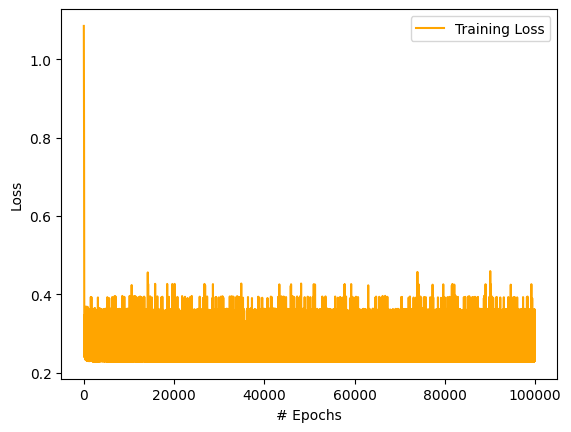

In [12]:
plt.plot(range(len(agent.train_loss)), agent.train_loss, color='orange', label='Training Loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

y_true = []
y_pred = []

with torch.no_grad():
    for i in range(len(env.data)):
        state = env.data.iloc[i, :-1].values
        label = env.data.iloc[i, -1]

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.epsilon_greedy_action(state_tensor)  # No need for .item()

        y_true.append(label)
        y_pred.append(action)  # Store action directly

accuracy = accuracy_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred) * 100
mcc = matthews_corrcoef(y_true, y_pred) * 100

print(f'Accuracy: {accuracy:.2f}%')



/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy

Accuracy: 94.11%


In [20]:
y_true = []
y_pred = []

# Assuming you have a test set for the environment, if not, you can use the entire dataset
# It's better to evaluate on unseen data if possible
# For demonstration purposes, we'll use the entire dataset
# If you have X_test and y_test for the environment, replace env.data with your test data

with torch.no_grad():
    # Iterate through the data to get predictions from the agent
    for i in range(len(env.data)):
        state = env.data.iloc[i, :-1].values
        label = env.data.iloc[i, -1]

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.epsilon_greedy_action(state_tensor, epsilon=0) # Use epsilon=0 for evaluation

        y_true.append(label)
        y_pred.append(action)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred) * 100
mcc = matthews_corrcoef(y_true, y_pred) * 100

print(f'Agent Performance:')
print(f'Accuracy: {accuracy:.2f}%')
print(f'F1 Score: {f1:.2f}%')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.2f}%')

/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy())  # Ensure it returns an int
/tmp/ipython-input-9-3639750843.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(action_values.argmax(dim=1).cpu().numpy

Agent Performance:
Accuracy: 99.00%
F1 Score: 0.00%
Matthews Correlation Coefficient (MCC): 0.00%
